# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

### Установка зависимостей

In [32]:
import os
import time
import random
import copy

import pickle
import numpy as np
import pandas as pd
from skimage import color, io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from skimage.transform import resize

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# размер батча
BATCH_SIZE = 16
# работаем на видеокарте
DEVICE = torch.device(0)
torch.cuda.set_device(DEVICE)

Установим сиды для воспроизводимости

In [4]:
SEED = 410

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode
        
        #
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        #
        
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(img, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Давайте посмотрим на наших героев внутри датасета.

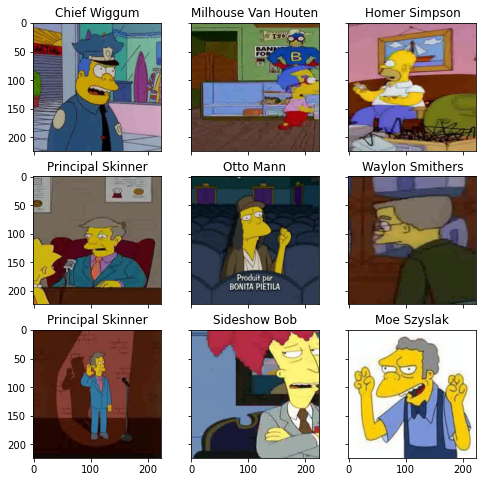

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Будем использовать предобученную ResNet50

In [11]:
model_resnet50 = models.resnet50(pretrained=True)
num_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_features, 42)
model_resnet50 = model_resnet50.cuda()

In [12]:
criterion = nn.CrossEntropyLoss()
# изменим на SGD
optimizer = optim.SGD(model_resnet50.parameters(), lr=0.001, momentum=0.9)
# добавим sheduler который будет варьировать learning rate каждые 7 эпох
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
dataloaders = {'train':train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_files), 'val':len(val_files)}

In [14]:
def train(model, criterion, optimizer, scheduler, num_epochs=200):
    start = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # обьединим fit и eval epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            processed_data = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                processed_data += inputs.size(0)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # сохраняем лучшую модель
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val_acc: {:4f}'.format(best_acc))

    # загружаем лучшую модель
    model.load_state_dict(best_model)
    return model

Запустим обучение сети.

In [15]:
model_resnet50 = train(model_resnet50, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9
train Loss: 0.8489 Acc: 0.8044
val Loss: 0.2471 Acc: 0.9364

Epoch 1/9
train Loss: 0.1933 Acc: 0.9554
val Loss: 0.1576 Acc: 0.9612

Epoch 2/9
train Loss: 0.0844 Acc: 0.9825
val Loss: 0.1329 Acc: 0.9690

Epoch 3/9
train Loss: 0.0409 Acc: 0.9924
val Loss: 0.1362 Acc: 0.9679

Epoch 4/9
train Loss: 0.0247 Acc: 0.9961
val Loss: 0.1148 Acc: 0.9746

Epoch 5/9
train Loss: 0.0158 Acc: 0.9976
val Loss: 0.1191 Acc: 0.9740

Epoch 6/9
train Loss: 0.0109 Acc: 0.9987
val Loss: 0.1165 Acc: 0.9759

Epoch 7/9
train Loss: 0.0084 Acc: 0.9989
val Loss: 0.1159 Acc: 0.9750

Epoch 8/9
train Loss: 0.0080 Acc: 0.9992
val Loss: 0.1142 Acc: 0.9736

Epoch 9/9
train Loss: 0.0073 Acc: 0.9995
val Loss: 0.1116 Acc: 0.9752

Training complete in 102m 35s
Best val_acc: 0.975927


Сделаем сабмит

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [18]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [20]:
probs = predict(model_resnet50, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [21]:
test_filenames = [path.name for path in test_dataset.files]

In [22]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [23]:
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [24]:
submit.to_csv('submission_1.csv', index=False)

![alt text](https://i.ibb.co/rtVRssM/k-C6-JJHs-IJHs.jpg)